# 2


In [32]:
from load_datasets import (
    train_val_generator,
    val_generator,
    train_generator,
    test_generator,
    X_train,
    X_val,
)
from helper_functions import flatten_list
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd

In [33]:
def create_Conv2D_MaxPooling2D_pairs(kernel_number):
    return [
        Conv2D(
            kernel_number,
            padding="same",
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(32, 32, 3),
        ),
        MaxPooling2D(pool_size=(2, 2), strides=2),
    ]

X_train.shape[1:]  # Input shape

(32, 32, 3)

In [34]:
def create_Dense_Dropout_pairs(node_dropout_pair):
    return [
        Dense(node_dropout_pair[0], activation="relu", kernel_initializer="he_normal"),
        Dropout(node_dropout_pair[1]),
    ]

In [35]:
def model_cnn_2_classes(
    cnn_kernel_numbers: list,
    mlp_node_dropout_pairs,
    *,
    name: str = "cnn_model_2_classes",
    optimizer=Adam(learning_rate=0.001),
    metrics=["acc"],
    flatten_layer_dropout_rate=.3
):
    flatten_layer=[Flatten(name="flatten_layer"), Dropout(flatten_layer_dropout_rate)]
    model = Sequential(
        flatten_list(
            [
                create_Conv2D_MaxPooling2D_pairs(kernel_number)
                for kernel_number in cnn_kernel_numbers
            ]
        )
        + flatten_layer
        + flatten_list(
            [
                create_Dense_Dropout_pairs(node_dropout_pair)
                for node_dropout_pair in mlp_node_dropout_pairs
            ]
        )
        + [Dense(1, activation="sigmoid", name="output_layer")],
        name=name,
    )
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    return model

In [36]:
def plot_and_print_model_metrics(metrics:pd.DataFrame):
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    print(f'val_acc: {metrics["val_acc"].iloc[-1]}')
    metrics[["loss", "val_loss"]].plot(ax=ax[0], grid=True)
    metrics[["acc", "val_acc"]].plot(ax=ax[1], grid=True)

In [37]:
int(len(X_train) / 32), int(len(X_val) / 32)

(50, 12)

In [38]:
def fit_then_evaluate_model(
    model,
    *,
    steps_per_epoch=50,
    validation_steps=12,
    model_fit_verbosity=0,
    print_model_summary=False
):
    early_stopper = EarlyStopping(
        monitor="val_acc", mode="max", patience=10, restore_best_weights=False
    )
    model.fit(
        train_val_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        callbacks=[early_stopper],
        validation_data=val_generator,
        validation_steps=validation_steps,
        verbose=model_fit_verbosity,
    )
    metrics = pd.DataFrame(model.history.history)
    plot_and_print_model_metrics(metrics)
    if print_model_summary:
        print(model.summary())

    return model

val_acc: 0.8828125


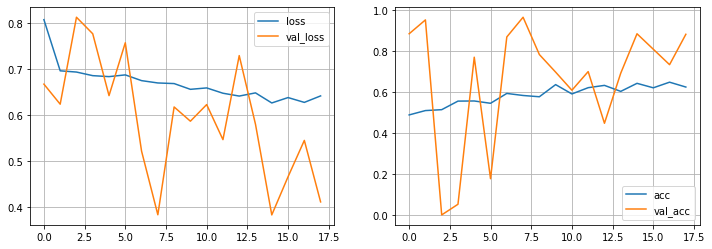

In [39]:
model_1__kernel_numbers = [32, 64, 128, 128]
model_1__node_dropout_pairs = [(512, 0)]
model_1 = model_cnn_2_classes(model_1__kernel_numbers, model_1__node_dropout_pairs, name="model_1")
fit_then_evaluate_model(model_1);

## b)


### Testing different kernel numbers

val_acc: 0.9973958134651184


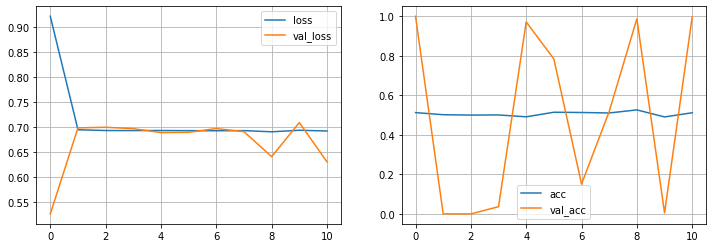

In [40]:
model_2__kernel_numbers = [32, 64, 128]
model_2 = model_cnn_2_classes(model_2__kernel_numbers, model_1__node_dropout_pairs, name='model_2')
fit_then_evaluate_model(model_2);

val_acc: 0.8828125


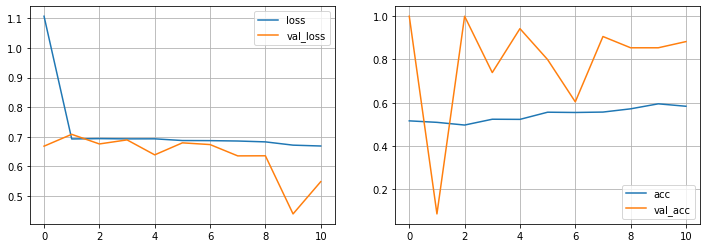

In [41]:
model_3__kernel_numbers = [32, 64, 128, 256]
model_3 = model_cnn_2_classes(model_3__kernel_numbers, model_1__node_dropout_pairs, name='model_3')
fit_then_evaluate_model(model_3);

### Testing different mlp layers

val_acc: 0.0


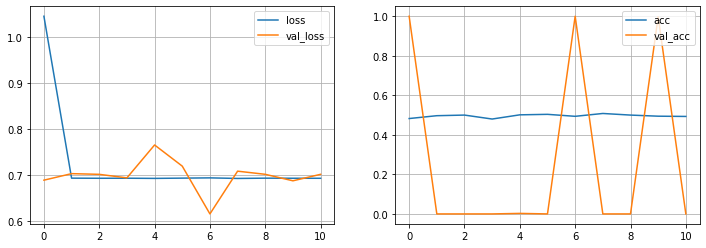

In [42]:
model_4__node_dropout_pairs = [(512, 0), (256,0)]
model_4 = model_cnn_2_classes(model_3__kernel_numbers, model_4__node_dropout_pairs, name='model_4')
fit_then_evaluate_model(model_4);

val_acc: 0.0


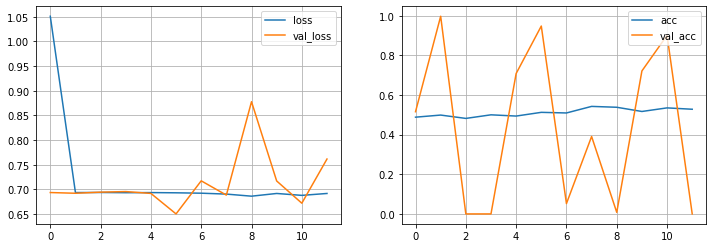

In [43]:
model_5__node_dropout_pairs = [(512, 0.3), (256,0.3)]
model_5 = model_cnn_2_classes(model_3__kernel_numbers, model_5__node_dropout_pairs, name='model_5')
fit_then_evaluate_model(model_5);

val_acc: 0.9869791865348816


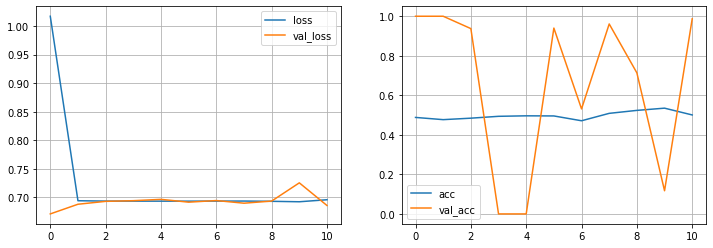

In [44]:
model_6__node_dropout_pairs = [(256, 0.3)]
model_6 = model_cnn_2_classes(model_3__kernel_numbers, model_6__node_dropout_pairs, name='model_6')
fit_then_evaluate_model(model_6);

val_acc: 1.0


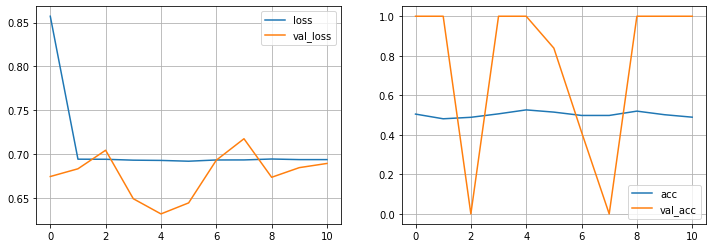

In [45]:
model_7__node_dropout_pairs = [(256, 0.3), (128, 0.3)]
model_7 = model_cnn_2_classes(model_3__kernel_numbers, model_7__node_dropout_pairs, name='model_7')
fit_then_evaluate_model(model_7);

val_acc: 0.0


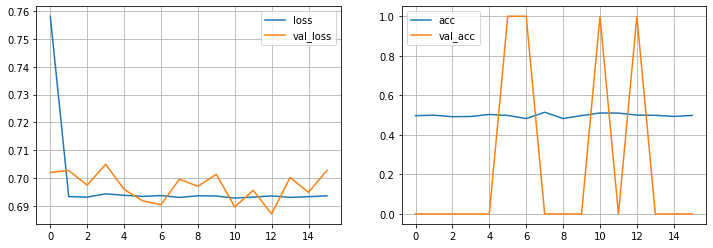

In [49]:
model_8__node_dropout_pairs = [(256, 0.3), (128, 0.3), (64, 0.3)]
model_8 = model_cnn_2_classes(model_1__kernel_numbers, model_8__node_dropout_pairs, name='model_8', flatten_layer_dropout_rate=.2)
fit_then_evaluate_model(model_8);

val_acc: 1.0


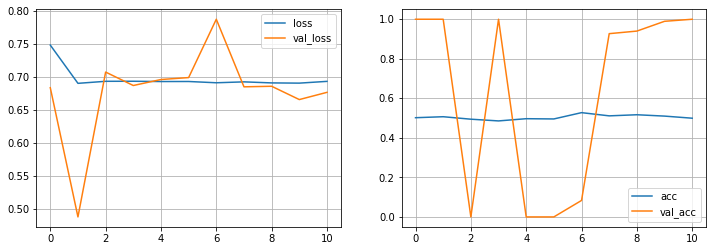

In [52]:
model_9__node_dropout_pairs = [(256, 0.3), (128, 0.3)]
model_9 = model_cnn_2_classes(model_3__kernel_numbers, model_9__node_dropout_pairs, name='model_9', flatten_layer_dropout_rate=.2)
fit_then_evaluate_model(model_9);

val_acc: 1.0


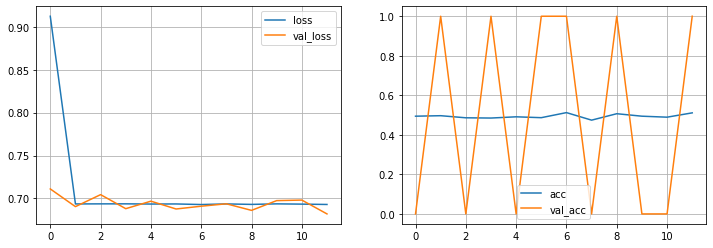

In [54]:
model_10__node_dropout_pairs = [(256, 0.3), (128, 0.3)]
model_10 = model_cnn_2_classes(model_3__kernel_numbers, model_10__node_dropout_pairs, name='model_10', flatten_layer_dropout_rate=.1)
fit_then_evaluate_model(model_10);